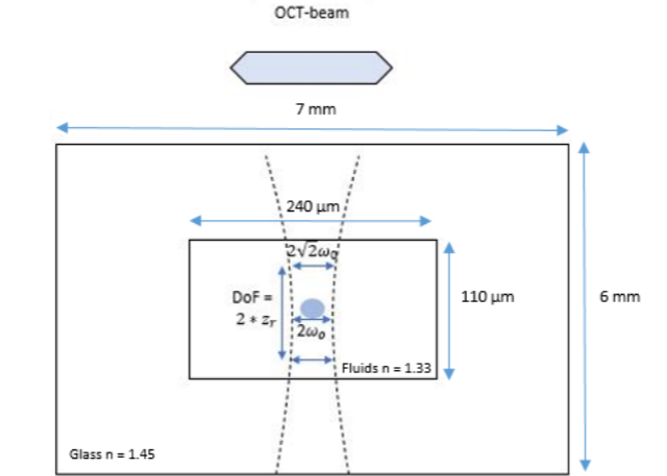

sources: mine github 

original source: https://gitlab.tudelft.nl/jeroenkalkman/optical-coherence-tomography


oct tutorial :

https://pcrl.sharepoint.com/sites/PHOREVERTeamsite/FGsWorkplace/Forms/AllItems.aspx?newTargetListUrl=%2Fsites%2FPHOREVERTeamsite%2FFGsWorkplace&viewpath=%2Fsites%2FPHOREVERTeamsite%2FFGsWorkplace%2FForms%2FAllItems%2Easpx&id=%2Fsites%2FPHOREVERTeamsite%2FFGsWorkplace%2FAll%20%2D%20system%20design&viewid=aa4d62c0%2Dcede%2D43a8%2D9700%2Dda912a5c9bbf

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('modules')
import ReadOCTfile
import DataProcessingOCT
import glob
import zipfile
import pandas as pd
from scipy.signal import find_peaks , medfilt

from PyMieSim.experiment import SphereSet, SourceSet, Setup, PhotodiodeSet, LPModeSet
from PyMieSim import measure
from PyMieSim.materials import BK7
from scipy.interpolate import interp1d
from scipy.stats import linregress

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False
import glob
import seaborn as sns

In [17]:
#loading filepaths and chirp for k-linearization
files = sorted(glob.glob('T:/2023-12-20-oct/*'))
zip_ref = zipfile.ZipFile(files[0],'r')
probeim_obj = zip_ref.open('data/Chirp.data')
probeim = probeim_obj.read()
dechirp = np.frombuffer(probeim, dtype=np.float32)

In [18]:
#main function that reads OCT file, does FFT, and returns OCT intensity image

def read_OCT(file_path, dechirp=dechirp):

    header,rawdata,spectrum,FOV = ReadOCTfile.OCTgetDataCombined(file_path,spectrumindex=0) 
    Ascanav = int(header.Ocity.Acquisition.IntensityAveraging.AScans.string)
    image = DataProcessingOCT.calc_Bscan(rawdata, spectrum, dechirp, Ascanav, apodization='hanning', filters='none', objective=None)
    OCTintensity = np.abs(image)**2
    return OCTintensity

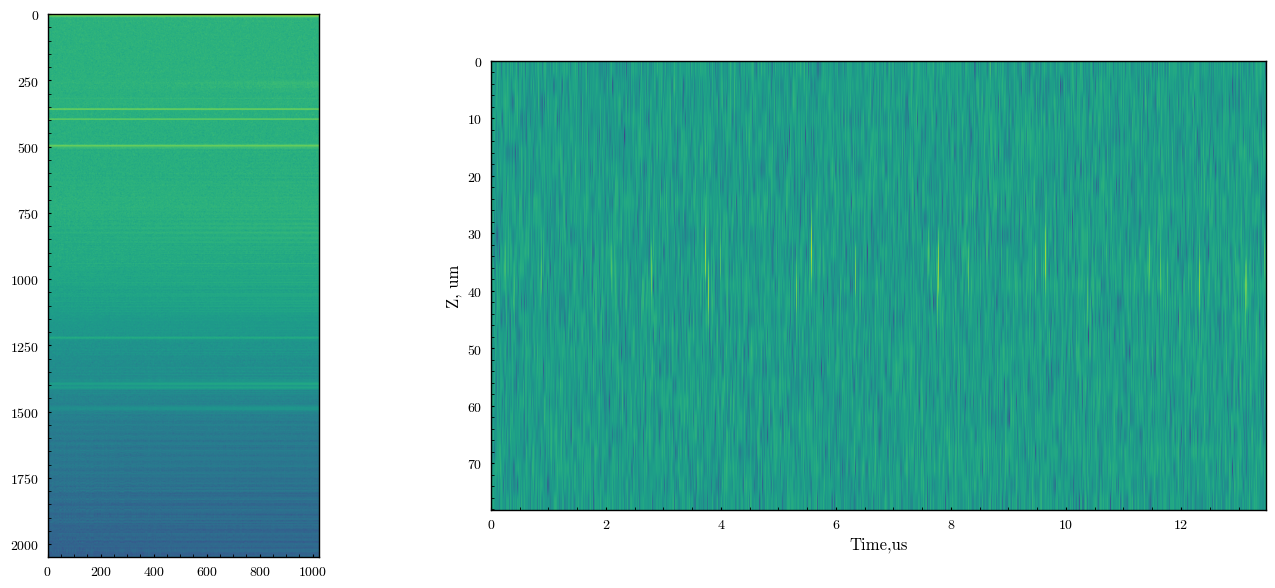

In [19]:
pixel_size_z_um = 2.89 
pixel_size_t_us = 1/76


image = read_OCT(files[-3])





plt.figure(figsize=(15,6))


plt.subplot(121)
plt.imshow(10*np.log10(image))


cuvette_image = 10*np.log10(image[365:392])
extent=[0, cuvette_image.shape[1] * pixel_size_t_us,  pixel_size_z_um* cuvette_image.shape[0], 0]


plt.subplot(122)
plt.imshow(cuvette_image,extent=extent,aspect=0.1,vmax=70)
plt.xlabel('Time,us')
plt.ylabel('Z, um')


plt.tight_layout()

In [12]:
files

['T:/2023-12-20-oct\\2023-12-20-1000nm-conc1_10to3-speed-0_05-4_0ul_s-1d-1.oct',
 'T:/2023-12-20-oct\\2023-12-20-1000nm-conc1_10to3-speed-0_05-4_0ul_s-1d-2.oct',
 'T:/2023-12-20-oct\\2023-12-20-1000nm-conc1_10to3-speed-0_05-4_0ul_s-1d-3.oct',
 'T:/2023-12-20-oct\\2023-12-20-1000nm-conc1_10to3-speed-0_05-4_0ul_s-1d-4.oct',
 'T:/2023-12-20-oct\\2023-12-20-1000nm-conc1_10to3-speed-0_05-4_0ul_s-1d-5.oct',
 'T:/2023-12-20-oct\\2023-12-20-200nm-conc1_10to4-speed-0_05-4_0ul_s-1d-1.oct',
 'T:/2023-12-20-oct\\2023-12-20-200nm-conc1_10to4-speed-0_05-4_0ul_s-1d-2.oct',
 'T:/2023-12-20-oct\\2023-12-20-200nm-conc1_10to4-speed-0_05-4_0ul_s-1d-3.oct',
 'T:/2023-12-20-oct\\2023-12-20-200nm-conc1_10to4-speed-0_05-4_0ul_s-1d-4.oct',
 'T:/2023-12-20-oct\\2023-12-20-200nm-conc1_10to4-speed-0_05-4_0ul_s-1d-5.oct',
 'T:/2023-12-20-oct\\2023-12-20-400nm-conc1_10to3-speed-0_05-4_0ul_s-1d-1.oct',
 'T:/2023-12-20-oct\\2023-12-20-400nm-conc1_10to3-speed-0_05-4_0ul_s-1d-2.oct',
 'T:/2023-12-20-oct\\2023-12-20-400

In [15]:
#concentration of sample of different polysterine_beads

concentrations_particles_per_ml = {200:2.17e12 / 10_000,
                   400: 2.28e11 / 1000,
                   600:8.59e10 / 1000,
                   800:3.56e10 / 1000,
                   1000: 1.85e10 / 1000}